Available columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


/tmp/ipython-input-1-544496937.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_hourly.asfreq('H')  # Ensure frequency is set
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_mo

ARIMA -> MAE: 0.6106, RMSE: 0.8246
Prophet -> MAE: 0.6164, RMSE: 0.8785
XGBoost -> MAE: 0.5748, RMSE: 0.8299

Model Comparison:
     Model       MAE      RMSE
0    ARIMA  0.610631  0.824558
1  Prophet  0.616418  0.878472
2  XGBoost  0.574770  0.829947


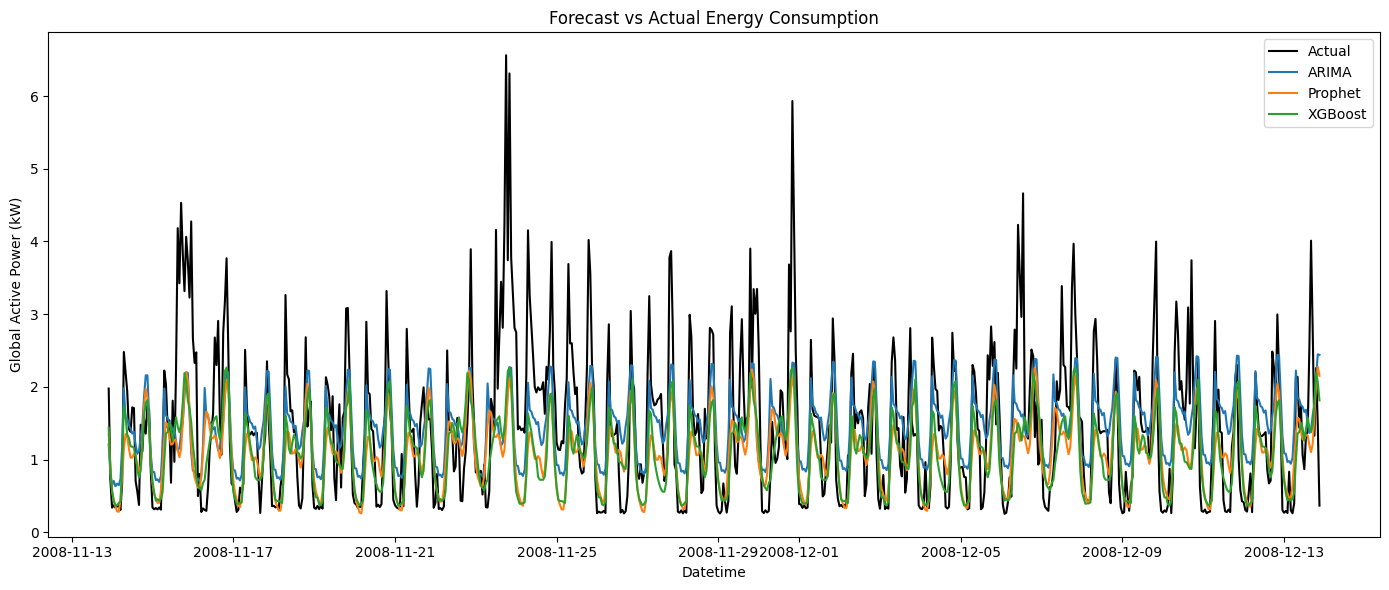

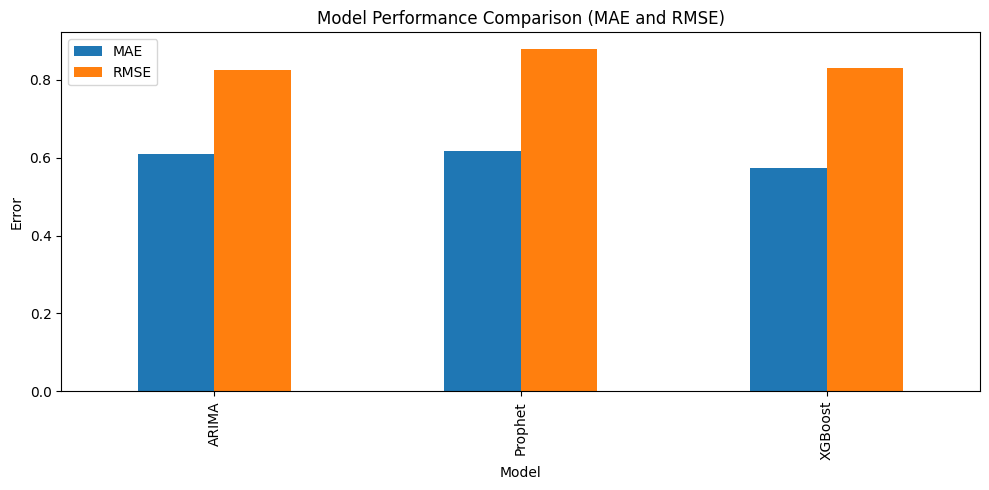

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import train_test_split

# Load and preprocess data
df = pd.read_csv('household_power_consumption.csv', sep=',', low_memory=False, na_values='?')
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names

# Print columns to debug missing 'Date'
print("Available columns:", df.columns.tolist())

# Check if 'Date' and 'Time' exist
if 'Date' in df.columns and 'Time' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    df.set_index('Datetime', inplace=True)
    df = df[['Global_active_power']].astype(float)
    df.dropna(inplace=True)

    # Resample to hourly usage
    df_hourly = df.resample('h').mean()
    df_hourly = df_hourly.asfreq('H')  # Ensure frequency is set
    df_hourly.dropna(inplace=True)

    # Time-based features
    features = df_hourly.copy()
    features['hour'] = features.index.hour
    features['dayofweek'] = features.index.dayofweek
    features['is_weekend'] = features['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

    # Determine dynamic test size (last 30 days)
    test_size = 24 * 30  # 30 days of hourly data
    if len(features) <= test_size:
        print("Error: Not enough data for a 30-day test set.")
    else:
        train = features.iloc[:-test_size]
        test = features.iloc[-test_size:]

        # ---------- ARIMA ----------
        sarimax_model = SARIMAX(train['Global_active_power'], order=(1,1,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_result = sarimax_model.fit(disp=False)
        y_pred_arima = sarimax_result.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean
        y_pred_arima.index = test.index  # Align with test

        # ---------- Prophet ----------
        df_prophet = features.reset_index()[['Datetime', 'Global_active_power']].rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
        df_train_p, df_test_p = train_test_split(df_prophet, test_size=len(test), shuffle=False)
        prophet_model = Prophet()
        prophet_model.fit(df_train_p)
        future = prophet_model.make_future_dataframe(periods=len(test), freq='H')
        forecast = prophet_model.predict(future)
        forecast.set_index('ds', inplace=True)
        y_pred_prophet = forecast.loc[test.index.intersection(forecast.index), 'yhat']

        # ---------- XGBoost ----------
        X = features.drop(columns=['Global_active_power'])
        y = features['Global_active_power']
        X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
        y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
        xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)

        # Evaluation
        def evaluate(y_true, y_pred, name):
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")
            return mae, rmse

        mae_arima, rmse_arima = evaluate(test['Global_active_power'], y_pred_arima, 'ARIMA')
        mae_prophet, rmse_prophet = evaluate(test.loc[y_pred_prophet.index, 'Global_active_power'], y_pred_prophet, 'Prophet')
        mae_xgb, rmse_xgb = evaluate(y_test, y_pred_xgb, 'XGBoost')

        # Comparison table
        results_df = pd.DataFrame({
            'Model': ['ARIMA', 'Prophet', 'XGBoost'],
            'MAE': [mae_arima, mae_prophet, mae_xgb],
            'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
        })
        print("\nModel Comparison:")
        print(results_df)

        # Plot actual vs forecast
        plt.figure(figsize=(14, 6))
        plt.plot(test.index, test['Global_active_power'], label='Actual', color='black')
        plt.plot(test.index, y_pred_arima, label='ARIMA')
        plt.plot(y_pred_prophet.index, y_pred_prophet, label='Prophet')
        plt.plot(test.index, y_pred_xgb, label='XGBoost')
        plt.legend()
        plt.title('Forecast vs Actual Energy Consumption')
        plt.xlabel('Datetime')
        plt.ylabel('Global Active Power (kW)')
        plt.tight_layout()
        plt.show()

        # Bar plot of MAE and RMSE
        results_df.set_index('Model').plot(kind='bar', figsize=(10,5))
        plt.title('Model Performance Comparison (MAE and RMSE)')
        plt.ylabel('Error')
        plt.tight_layout()
        plt.show()
else:
    print("Error: 'Date' and/or 'Time' columns not found in the dataset. Please check column names.")
